### tSNE medthod

tSNE stand as t-Distributed Stochastic Neighbor Embedding. It is a tool to visualize high-dimensional data into low-dimensional data, like two- or three-dimensional. The basic idea of tSNE is to represent similar objects in high-dimensional by nearby low-dimensional points and represent dissimilar objects in high-dimensional by distant low -dimensional points.

### How tSNE works

First, measure the local similarities between points in high-dimensional, local similarities means we are only going to look at the similarities to nearby points. The way we measure the similarities between the points is first we pick up a point in high-dimensional, and we center a Gaussian distribution over this point, then we are going to measure the probability density of all other points under this Gaussian using this function:

$$p_{j|i}=\frac{exp(-\frac{(\|x_i-x_j\|)^2}{2\sigma^{2}_{i}})}{\sum_{k\neq{i}}exp(-\frac{(\|x_i-x_k\|)^2}{2\sigma^{2}_{i}})}$$

By doing this, we will get a set of probabilities which basically measure the similarity between pairs of points. If two points are close in the original high-dimensional space the value of $p_{j|i}$ will be large and if the two points are far from each other in the high-dimensional space, the value of $p_{j|i}$ will be basically infinitesimal. And since the Gaussian has a fixed perplexity, we will not normalize over all pairs of points, we will only measure the point within the bandwidth we give to the point at the beginning.
Also, for the pair of points $p_i$ and $p_j$ , we are going to get the symmetrized version of the conditionals, which is:


$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2}$$

After measure the similarities in the high-dimensional space, we are going to represent each high-dimensional object by a point in the low-dimensional space. What we need is that the similarities we compute in the low-dimensional space reflect the similarities in the high-dimensional space as well as possible. To do this, we will also set a kernel to a point and measure the density of all the other point under this distribution, and then we are going to re-normalize the similarity. The kernel used in the low-dimensional space is not a Gaussian kernel, is a Student-t distribution which makes the function look like this:

$$q_{ij}=\frac{(1+\|y_i-y_j\|^2)^{-1}}{\sum_{k=i}{(1+\|y_k-y_l\|^2)^{-1}}}$$

The reason we use the Student-t distribution is that when we embedding high-dimensional data into low-dimensional maps, we want the dissimilar points to be far apart in the low-dimensional map. This heavy tailed distribution allows this to happen.

After we compute the $p_{ij}$ in high-dimensional space and the $q_{ij}$ in the low-dimensional space, we need a method to measure the difference between these two values to see if we have a good embedding. The way we measure the difference between these two probability distribution is using Kullback-Leibler divergence and it is given by:

$$C=KL(P\|Q)=\sum_{i}\sum_{j\neq{i}}p_{ij}\log{\frac{p_{ij}}{q_{ij}}}$$

This Kullback-Leibler divergence allow us to lay out the points in the low-dimensional space and make them reflect the similarities of high-dimensional space as well as possible which means that for each pair points this Kullback-Leibler divergence is minimized. In order to do that, we are going to do gradient descent in the Kullback-Leibler divergence, which boils down to just moving the points around in such a way that this Kullback-Leibler divergence becomes small.

And the way we move a single point in the map in order to get a lower Kullback-Leibler divergence is by using this function:

$$\frac{\partial{C}}{\partial{y_i}}=4\sum_{j\neq{i}}(p_{ij}-q_{ij})(y_i-y_j)(1+\|y_i-y_j\|^2)^{-1}$$

### Implement tSNE

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import manifold

In [16]:
df = pd.read_excel(open('CTG.xls','rb'),sheet_name = 'Data')
df = df.dropna(axis = 1, how = 'all')
df = df.dropna(axis = 0, how = 'any')

In [17]:
df = df.values

In [29]:
X = df[0:].T
y = np.zeros(2126)
for i in range(0,2126):
    y[i] = i
print(X.dtype)
print(X.shape)
print(X)

float64
(42, 2126)
[[ 2.400e+02  5.000e+00  1.770e+02 ...  1.576e+03  1.576e+03  2.796e+03]
 [ 3.570e+02  6.320e+02  7.790e+02 ...  2.596e+03  3.049e+03  3.415e+03]
 [ 0.000e+00  4.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  1.000e+00]
 ...
 [-1.000e+00 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]
 [ 9.000e+00  6.000e+00  6.000e+00 ...  5.000e+00  5.000e+00  1.000e+00]
 [ 2.000e+00  1.000e+00  1.000e+00 ...  2.000e+00  2.000e+00  1.000e+00]]


In [30]:
X1 = X[9:30]
X2 = X[40:]
X = np.vstack((X1, X2)).T
print(X.shape)
print(X.dtype)
print(X)

(2126, 23)
float64
[[1.20000000e+02 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  9.00000000e+00 2.00000000e+00]
 [1.32000000e+02 6.37958533e-03 0.00000000e+00 ... 0.00000000e+00
  6.00000000e+00 1.00000000e+00]
 [1.33000000e+02 3.32225914e-03 0.00000000e+00 ... 0.00000000e+00
  6.00000000e+00 1.00000000e+00]
 ...
 [1.40000000e+02 9.80392157e-04 0.00000000e+00 ... 1.00000000e+00
  5.00000000e+00 2.00000000e+00]
 [1.40000000e+02 6.78886626e-04 0.00000000e+00 ... 1.00000000e+00
  5.00000000e+00 2.00000000e+00]
 [1.42000000e+02 1.61550889e-03 1.61550889e-03 ... 0.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [31]:
n_samples = X.shape
n_features = X.shape
n_neighbors = 30

In [32]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=30)
t0 = time()
X_tsne = tsne.fit_transform(X).T
print(X_tsne.shape)
print(X_tsne)

Computing t-SNE embedding
(2, 2126)
[[ 20.071758  -18.52462   -18.53253   ...  -6.16618    -6.1466947
   -1.5986842]
 [ 42.468067   40.759285   40.76178   ...  -9.316162   -9.302801
  -52.482803 ]]


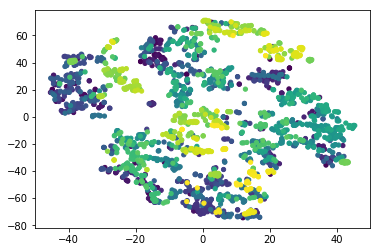

In [33]:
plt.scatter(X_tsne[0], X_tsne[1], s=18, c=y, alpha=1)
plt.show()

### Reference
[1]https://opentsne.readthedocs.io/en/latest/tsne_algorithm.html

[2]https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

[3]L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.

[4]https://lvdmaaten.github.io/tsne/